In [1]:
import matplotlib.pyplot as plt
import numpy as np
from rasterio import plot
import pandas as pd
import sys
import os
import gdal


from osgeo import osr, gdal, ogr

#custom files import

import skimage

from skimage import morphology

# from quality_assessment import *
data_folder_path = '/home/chris/Desktop/diploma/Diploma-Workspace/Data/'
labels_folder_path = '/home/chris/Desktop/diploma/Diploma-Workspace/Ground_Truth_Data/'
shapefile_folder = 'Shapefiles/'

cropped_data ='cropped_data/'


#IMPORT LABELS

crop_name = ['Cotton', 'Corn', 'Peanuts']
mask_suffix = '_mask.tif'
#Read as TIF
crop_data_tif = gdal.Open(labels_folder_path + 'CDL.tif')
crop_mask_tif = gdal.Open(labels_folder_path + 'CMASK.tif')
crops_only_tif = gdal.Open(labels_folder_path + 'CDL_CROPS_ONLY.tif')

cotton_tif = gdal.Open(labels_folder_path + crop_name[0] + mask_suffix)
#fallow_2_tif = gdal.Open(labels_folder_path + 'CDL_FALLOW_2.tif')
peanuts_tif = gdal.Open(labels_folder_path + crop_name[2] + mask_suffix)
#other_hay_4_tif = gdal.Open(labels_folder_path + 'CDL_OTHER_HAY_NO_ALFALA_4.tif')
corn_tif = gdal.Open(labels_folder_path + crop_name[1] + mask_suffix)

crops_tifs = [cotton_tif, corn_tif, peanuts_tif]

#Read as Arrays
crop_data = np.array(crop_data_tif.GetRasterBand(1).ReadAsArray())# crop_data_tif.read(1).astype('float64')
crop_mask = np.array(crop_mask_tif.GetRasterBand(1).ReadAsArray()) #crop_mask_tif.read(1).astype('float64')
crops_only = np.array(crops_only_tif.GetRasterBand(1).ReadAsArray()) #crops_only_tif.read(1).astype('float64')

cotton_array = np.array(cotton_tif.GetRasterBand(1).ReadAsArray()) #cotton_1_tif.read(1).astype('float64')
#fallow_2 = np.array(fallow_2_tif.GetRasterBand(1).ReadAsArray()) #fallow_2_tif.read(1).astype('float64')
peanuts_array = np.array(peanuts_tif.GetRasterBand(1).ReadAsArray()) #peanuts_3_tif.read(1).astype('float64')
#other_hay_4 = np.array(other_hay_4_tif.GetRasterBand(1).ReadAsArray()) #other_hay_4_tif.read(1).astype('float64')
corn_array = np.array(corn_tif.GetRasterBand(1).ReadAsArray()) #corn_5_tif.read(1).astype('float64')

crops_arrays_list = [cotton_array, corn_array, peanuts_array]

#read csv with crops type
labels = pd.read_csv(labels_folder_path + 'CDL_data.tif.vat.csv')
labels = labels.rename(columns=lambda x: x.strip())
existing_labels = pd.read_csv(labels_folder_path + 'cdl_existing_labels.csv')
existing_labels = existing_labels.rename(columns=lambda x: x.strip())
existing_crop_labels = pd.read_csv(labels_folder_path + 'cdl_existing_crop_labels.csv')
existing_crop_labels = existing_labels.rename(columns=lambda x: x.strip())

idx1 = (pd.Index(existing_labels['Value'])).union([0])
idx2 = np.unique(crops_only)

# print((idx1))
# print((idx2))

all_existing_labels = labels[labels['VALUE'].isin(idx1)]
crop_existing_labels = labels[labels['VALUE'].isin(idx2)]

# print(all_existing_labels)
# print(crop_existing_labels)

In [2]:
def array_to_raster(array, old_raster_used_for_projection, save_path):

    width = old_raster_used_for_projection.RasterYSize
    height = old_raster_used_for_projection.RasterXSize
    gt = old_raster_used_for_projection.GetGeoTransform()
    wkt_projection = old_raster_used_for_projection.GetProjectionRef()

    
    if len(array.shape):
        array = np.expand_dims(array, axis=0)

    no_bands =  array.shape[0]

    
    driver = gdal.GetDriverByName('GTiff')
    DataSet = driver.Create(save_path, height, width, no_bands, gdal.GDT_Float64)
    DataSet.SetGeoTransform(gt)
    DataSet.SetProjection(wkt_projection)
    
    
    for i, image in enumerate(array, 1):
        DataSet.GetRasterBand(i).WriteArray(image)
    DataSet = None
    
    return save_path

In [3]:
def raster_to_vector_polygonize(raster_path, save_path, save_name):
    gdal.UseExceptions()
    src_ds = gdal.Open(raster_path)
    if src_ds is None:
        print('Unable to open %s' % raster_path)
        sys.exit(1)
    srcband = src_ds.GetRasterBand(1) 
    srs = osr.SpatialReference()
    srs.ImportFromWkt(src_ds.GetProjection())

    drv = ogr.GetDriverByName("ESRI Shapefile")
    dst_ds = drv.CreateDataSource(save_path)

    dst_layer = dst_ds.CreateLayer(save_name, srs = srs )
    newField = ogr.FieldDefn('Area', ogr.OFTReal)
    dst_layer.CreateField(newField)
    gdal.Polygonize(srcband, None, dst_layer, 0, [], 
    callback=None )
    
    return save_path

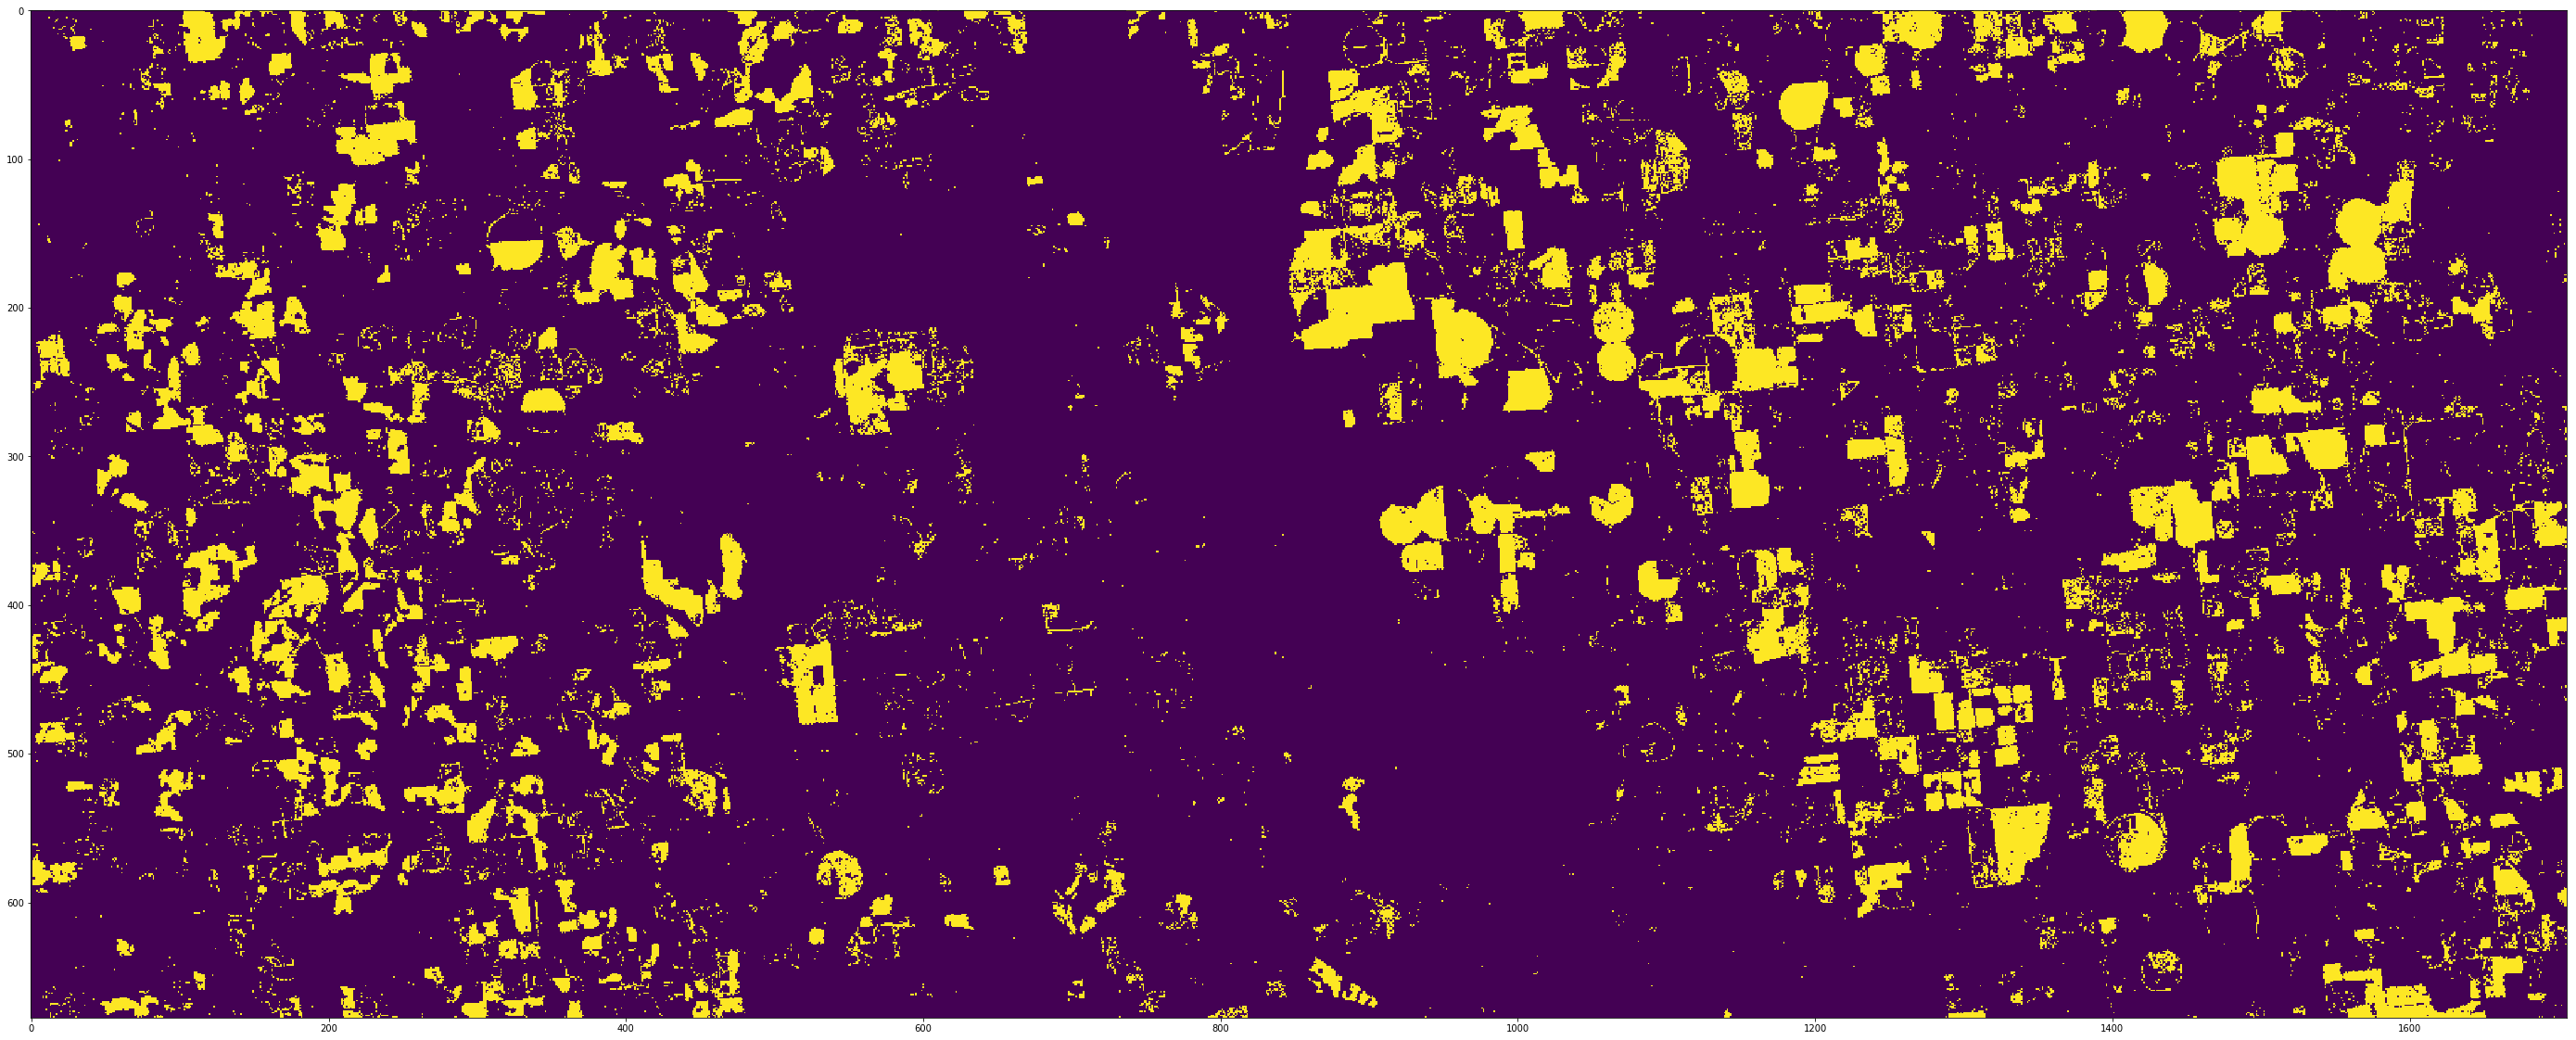

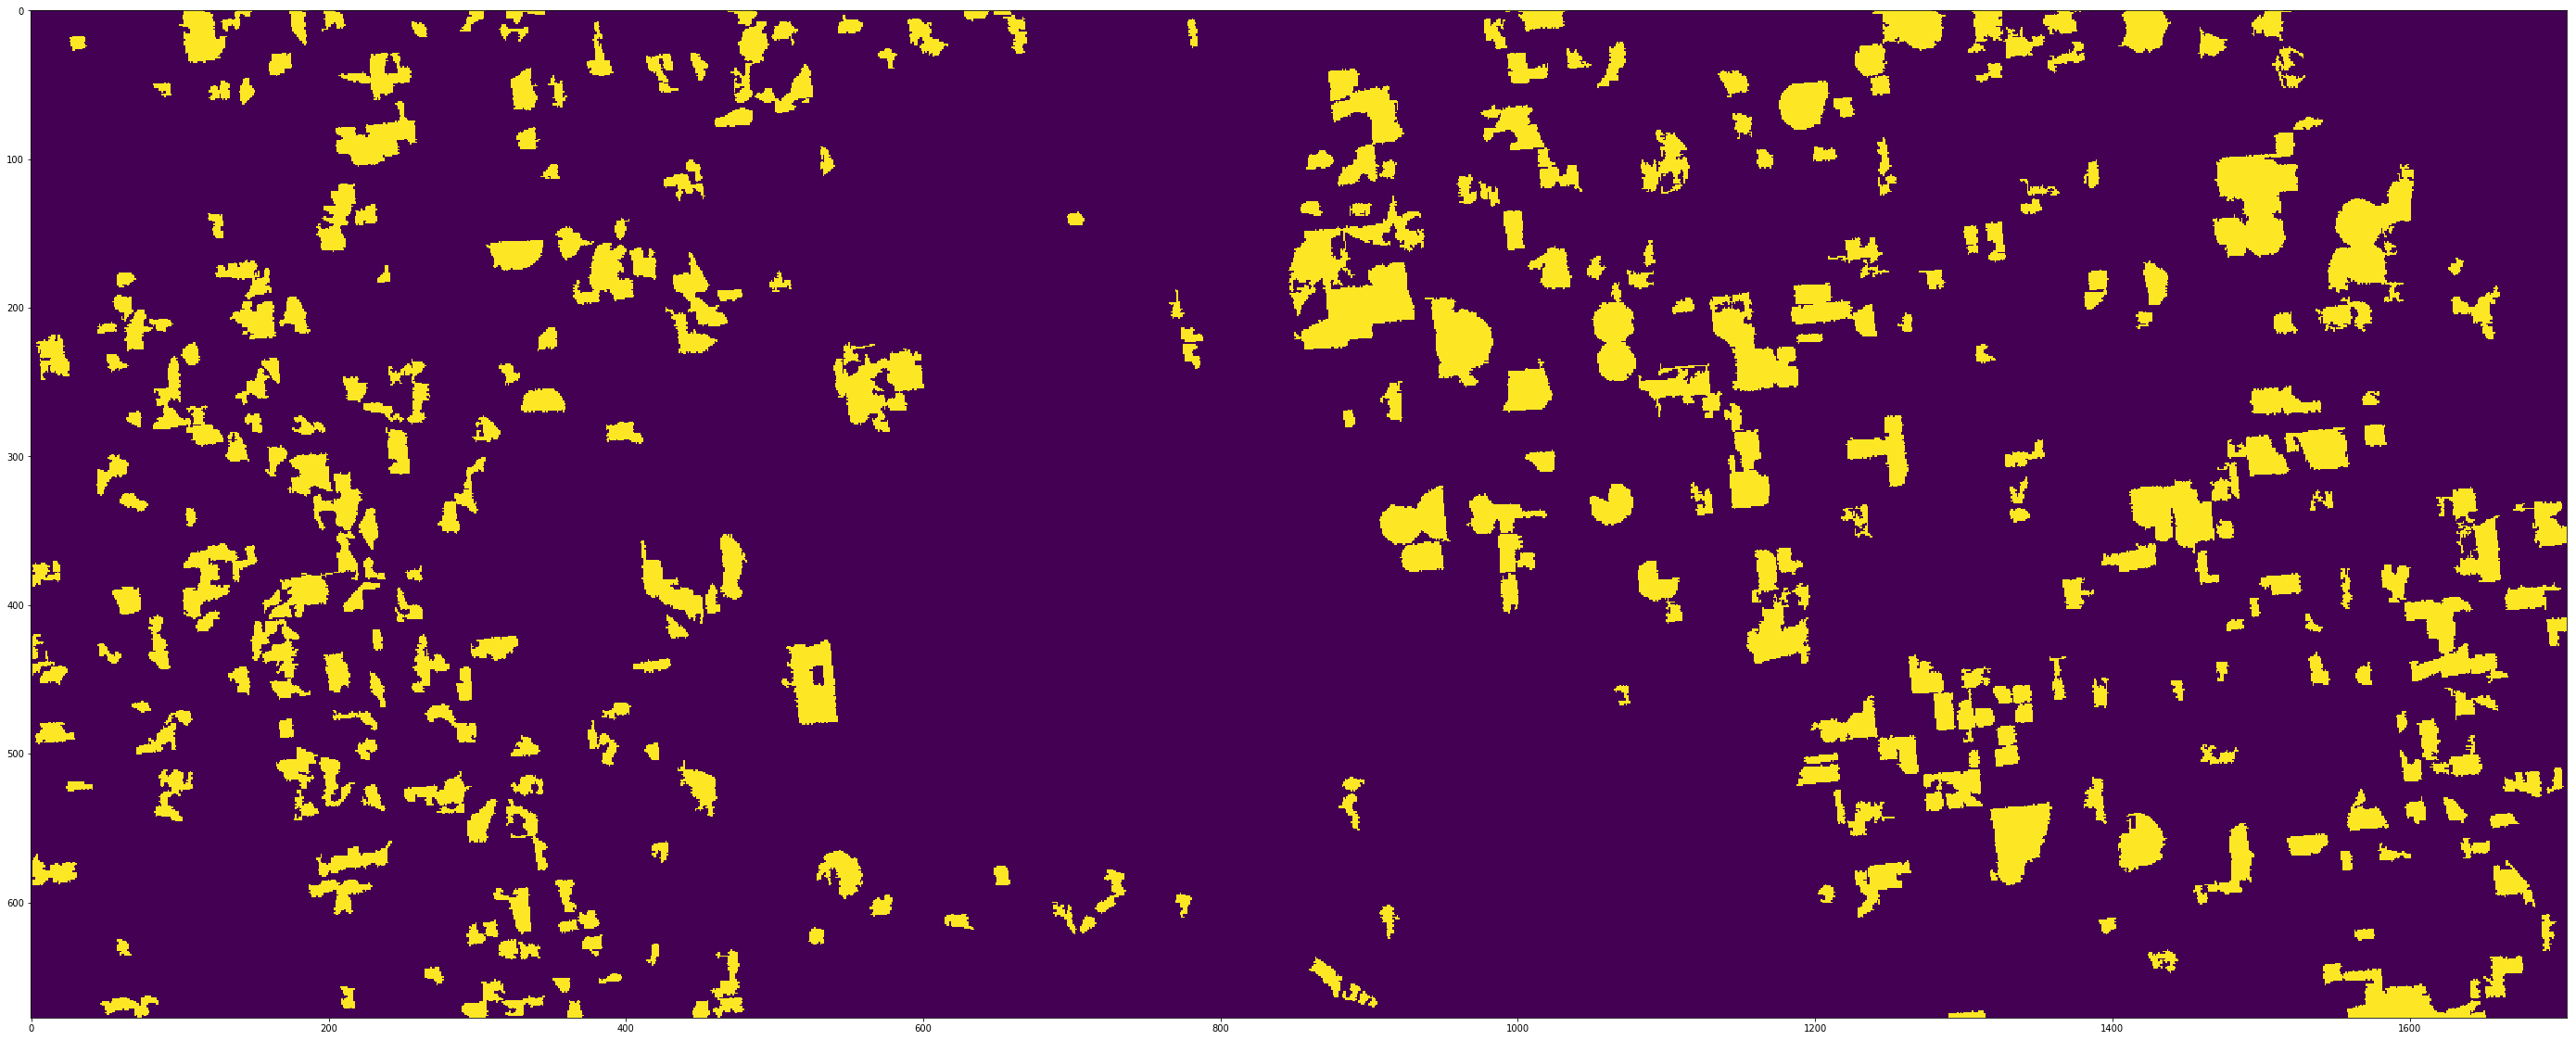

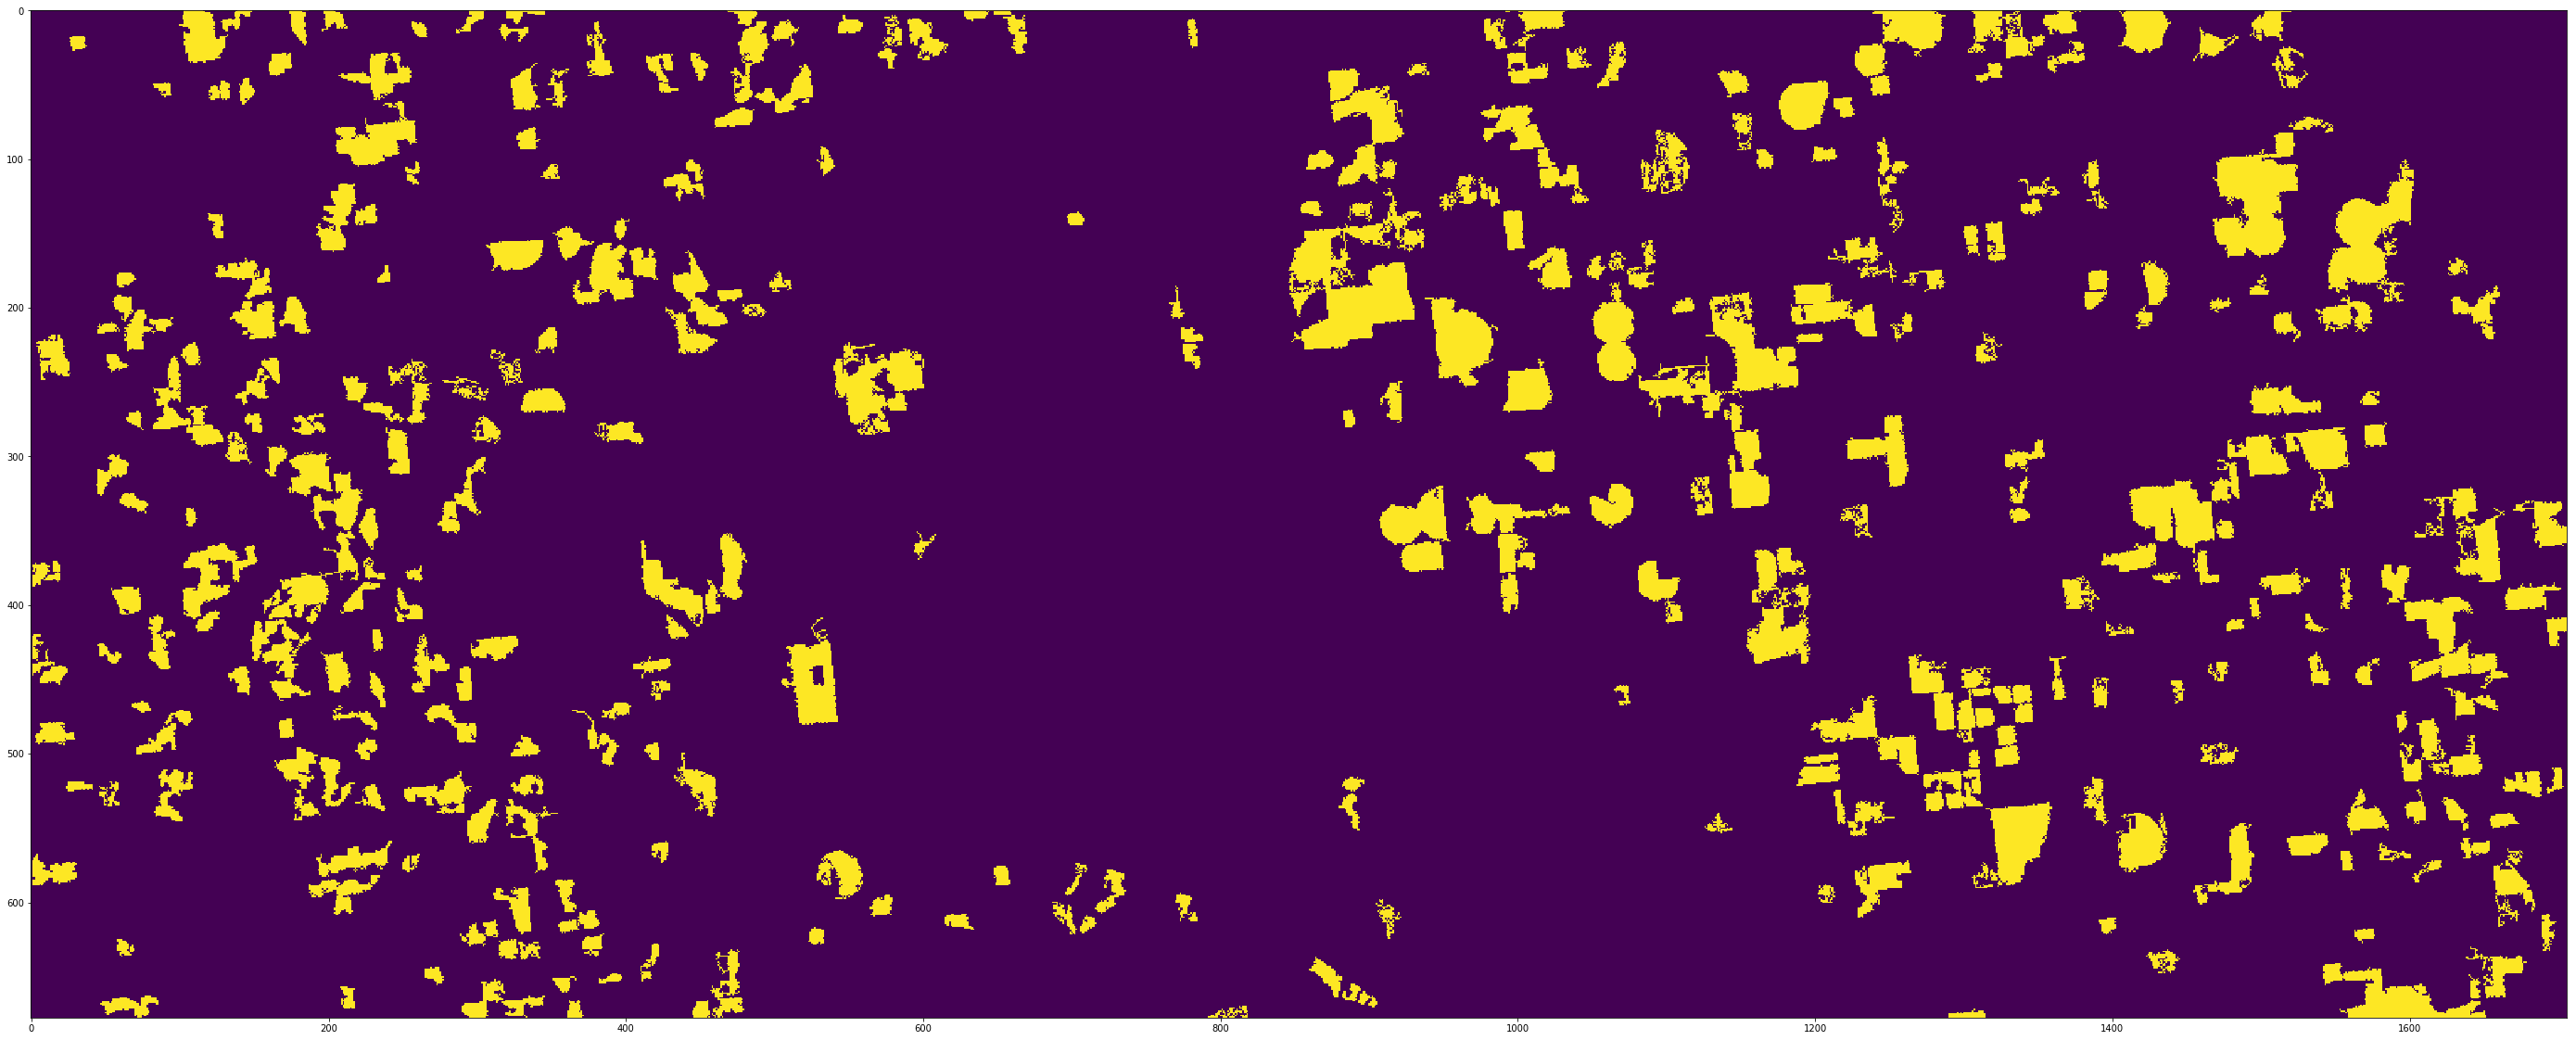

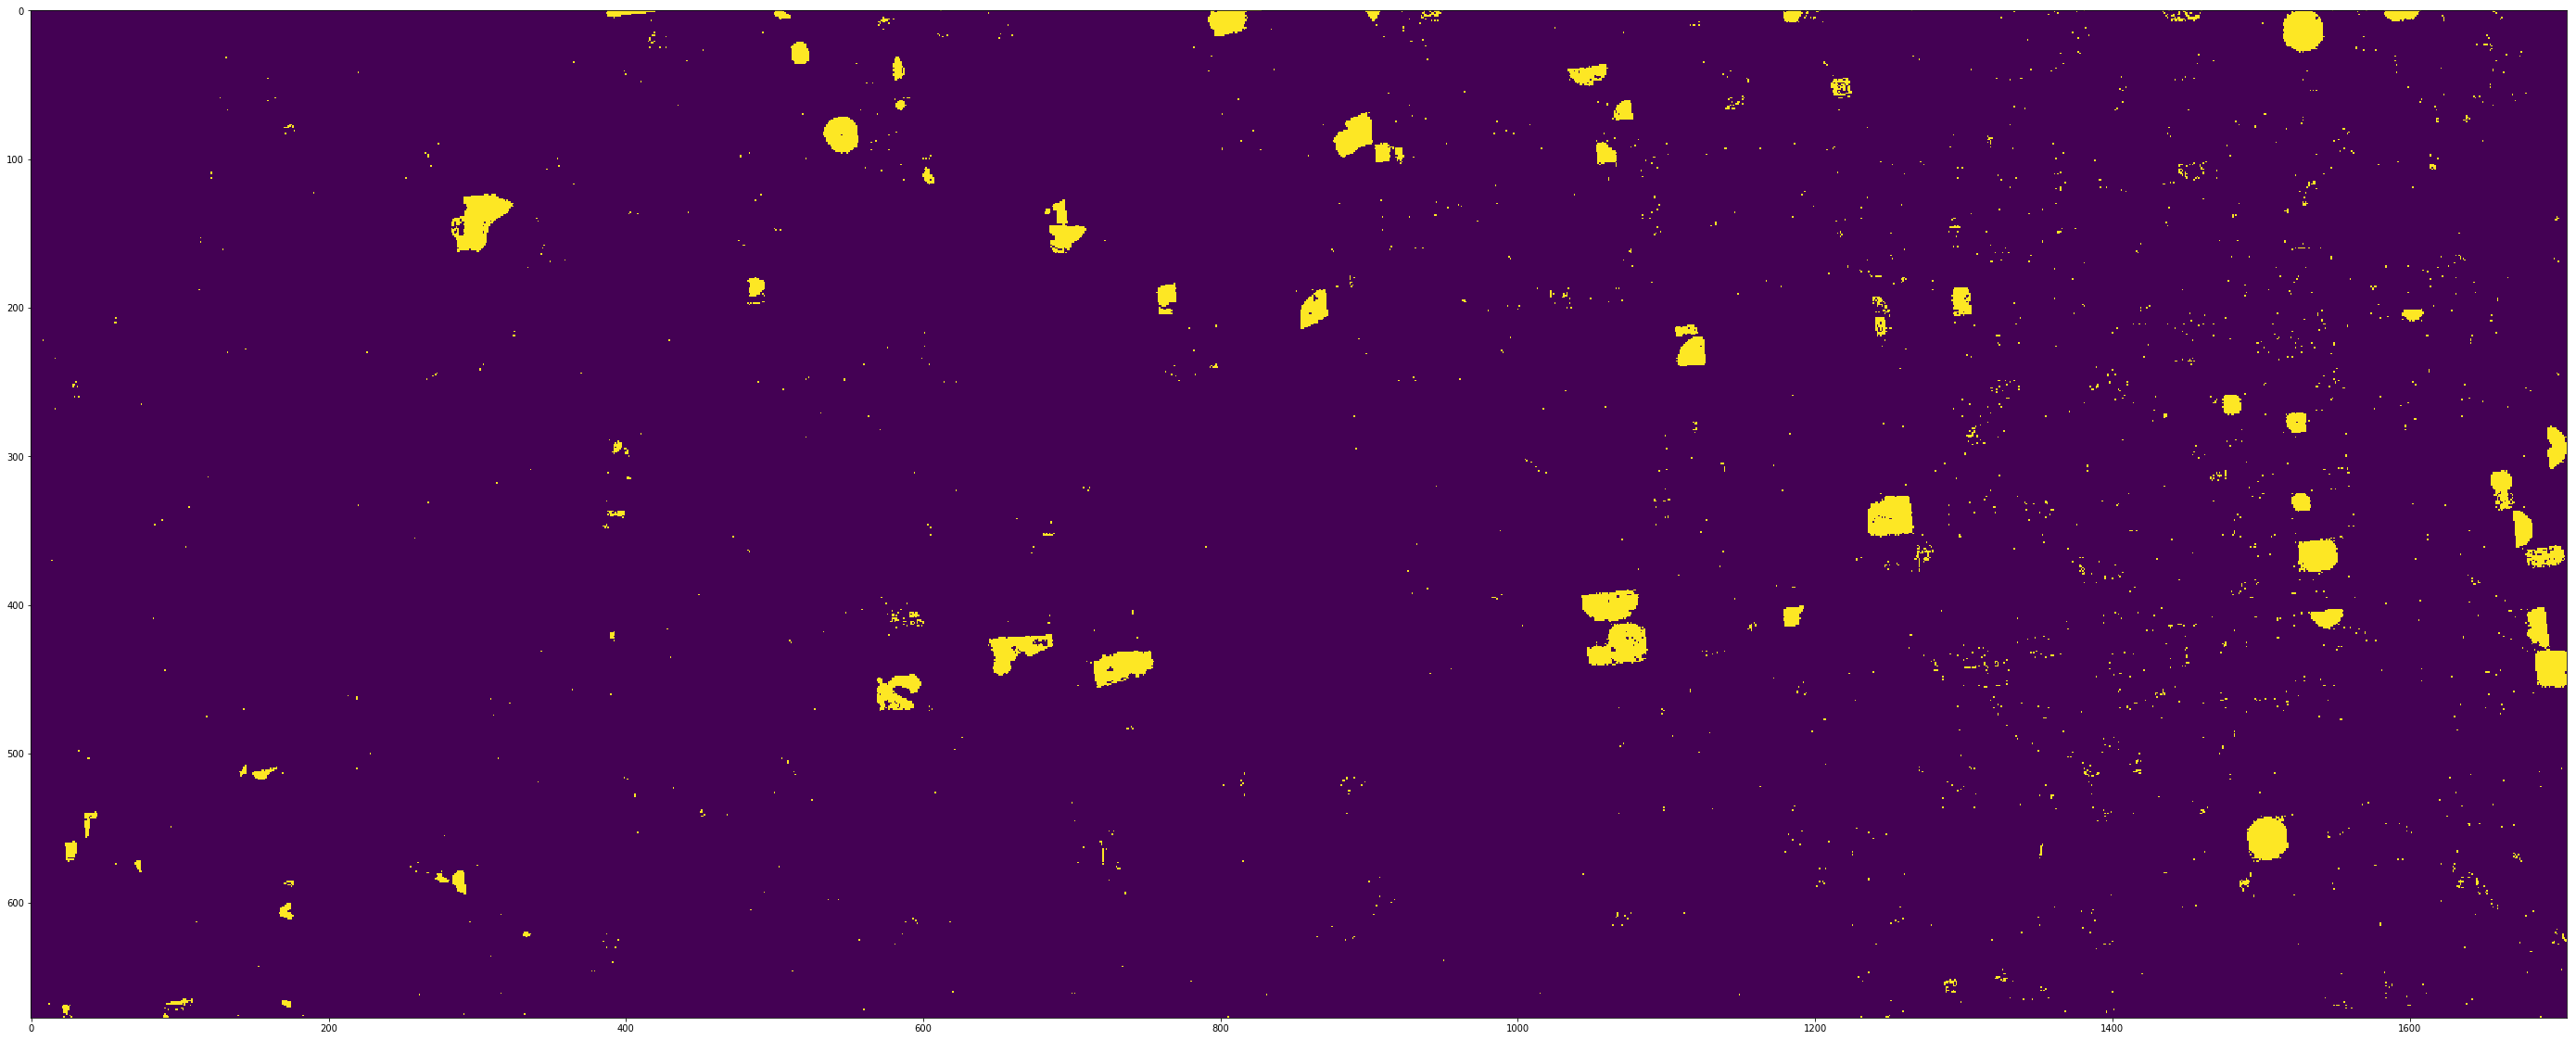

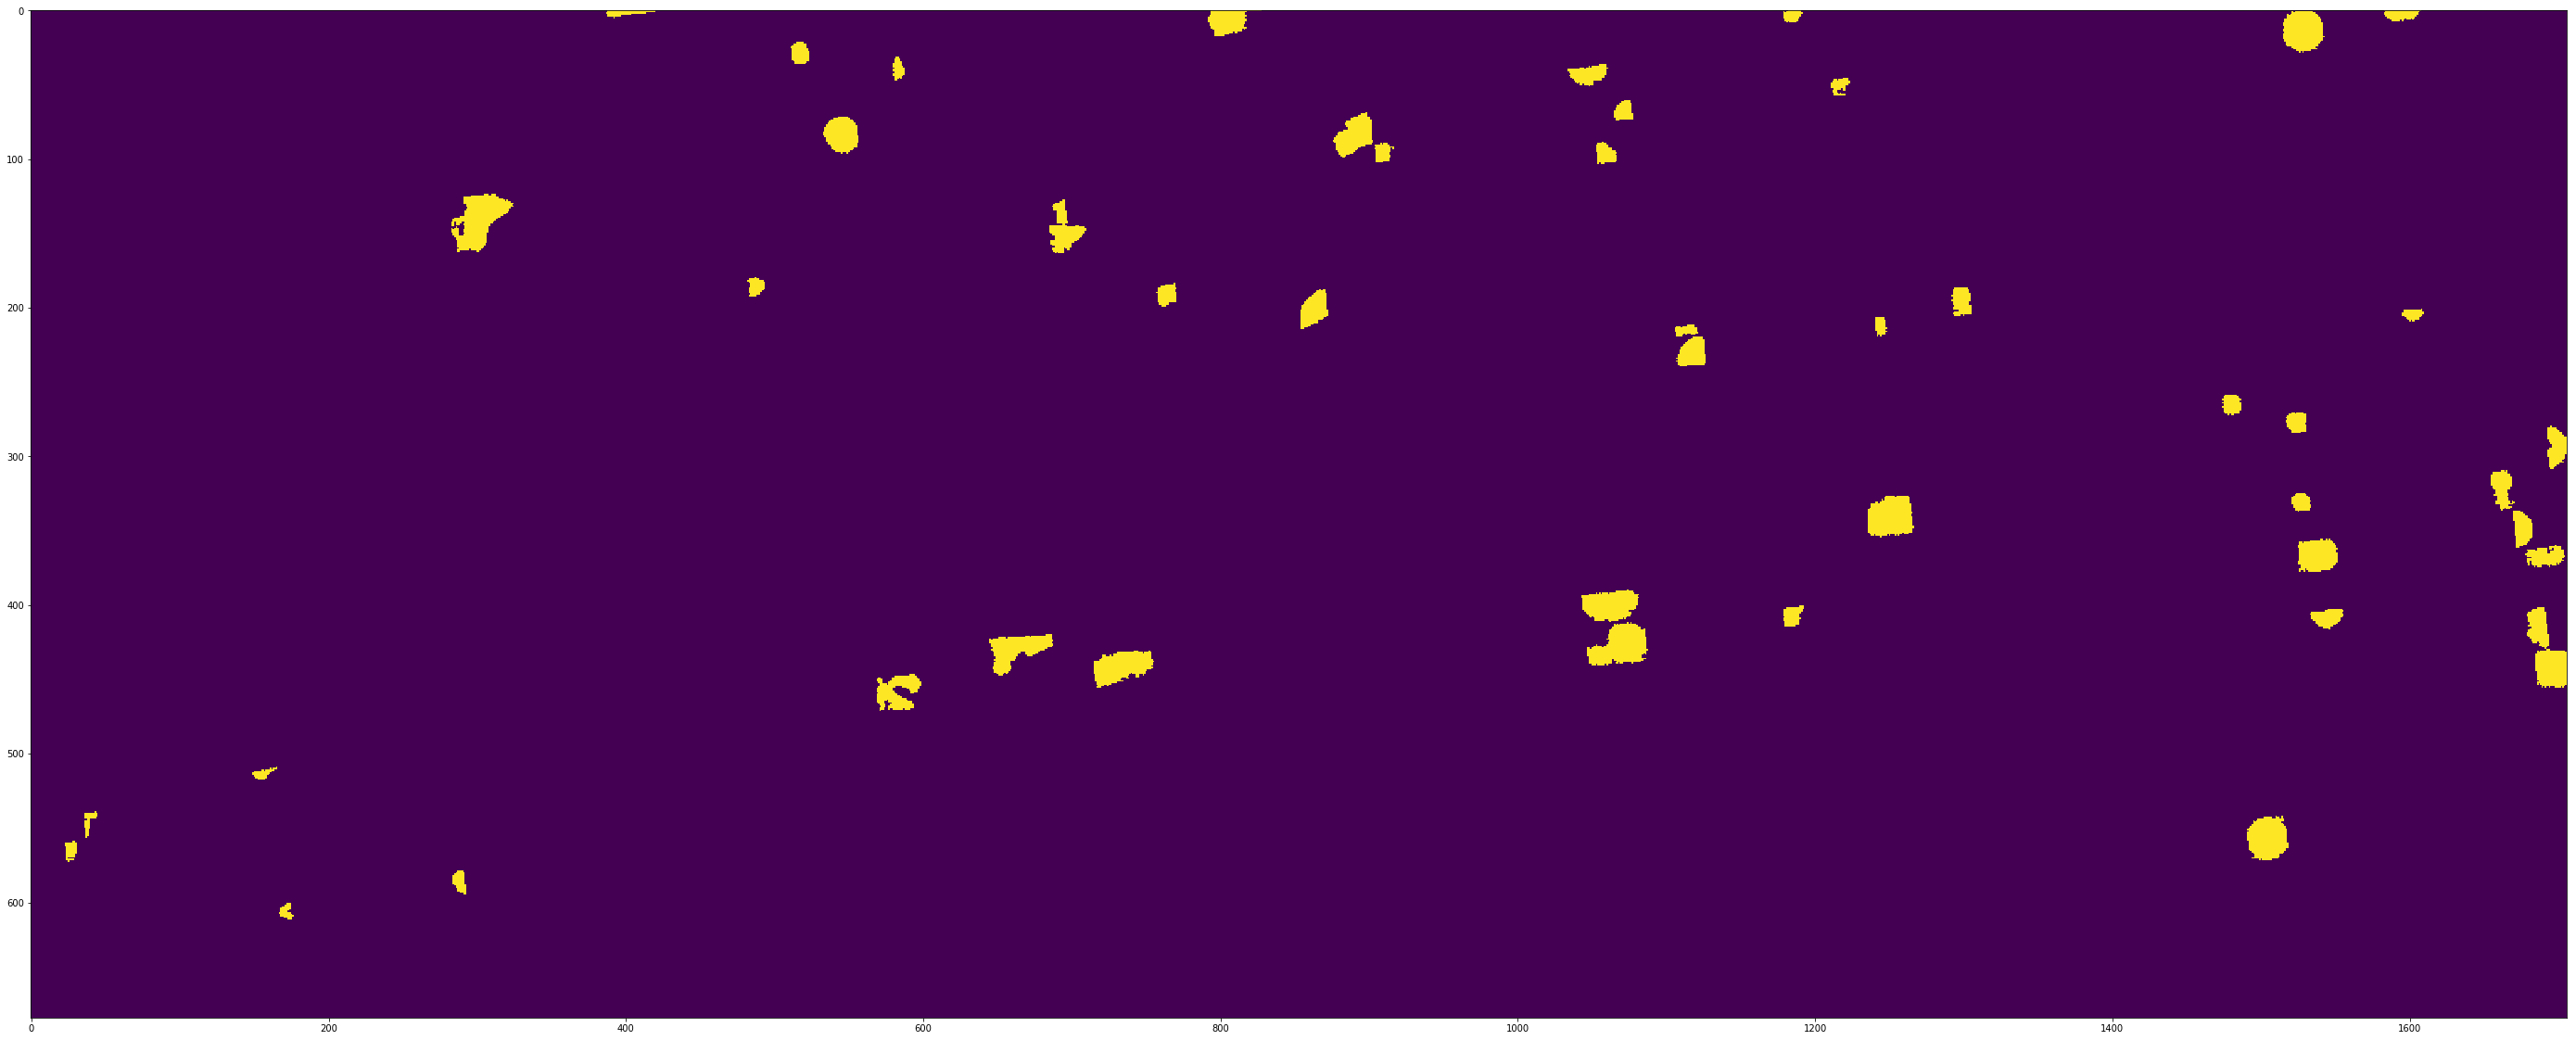

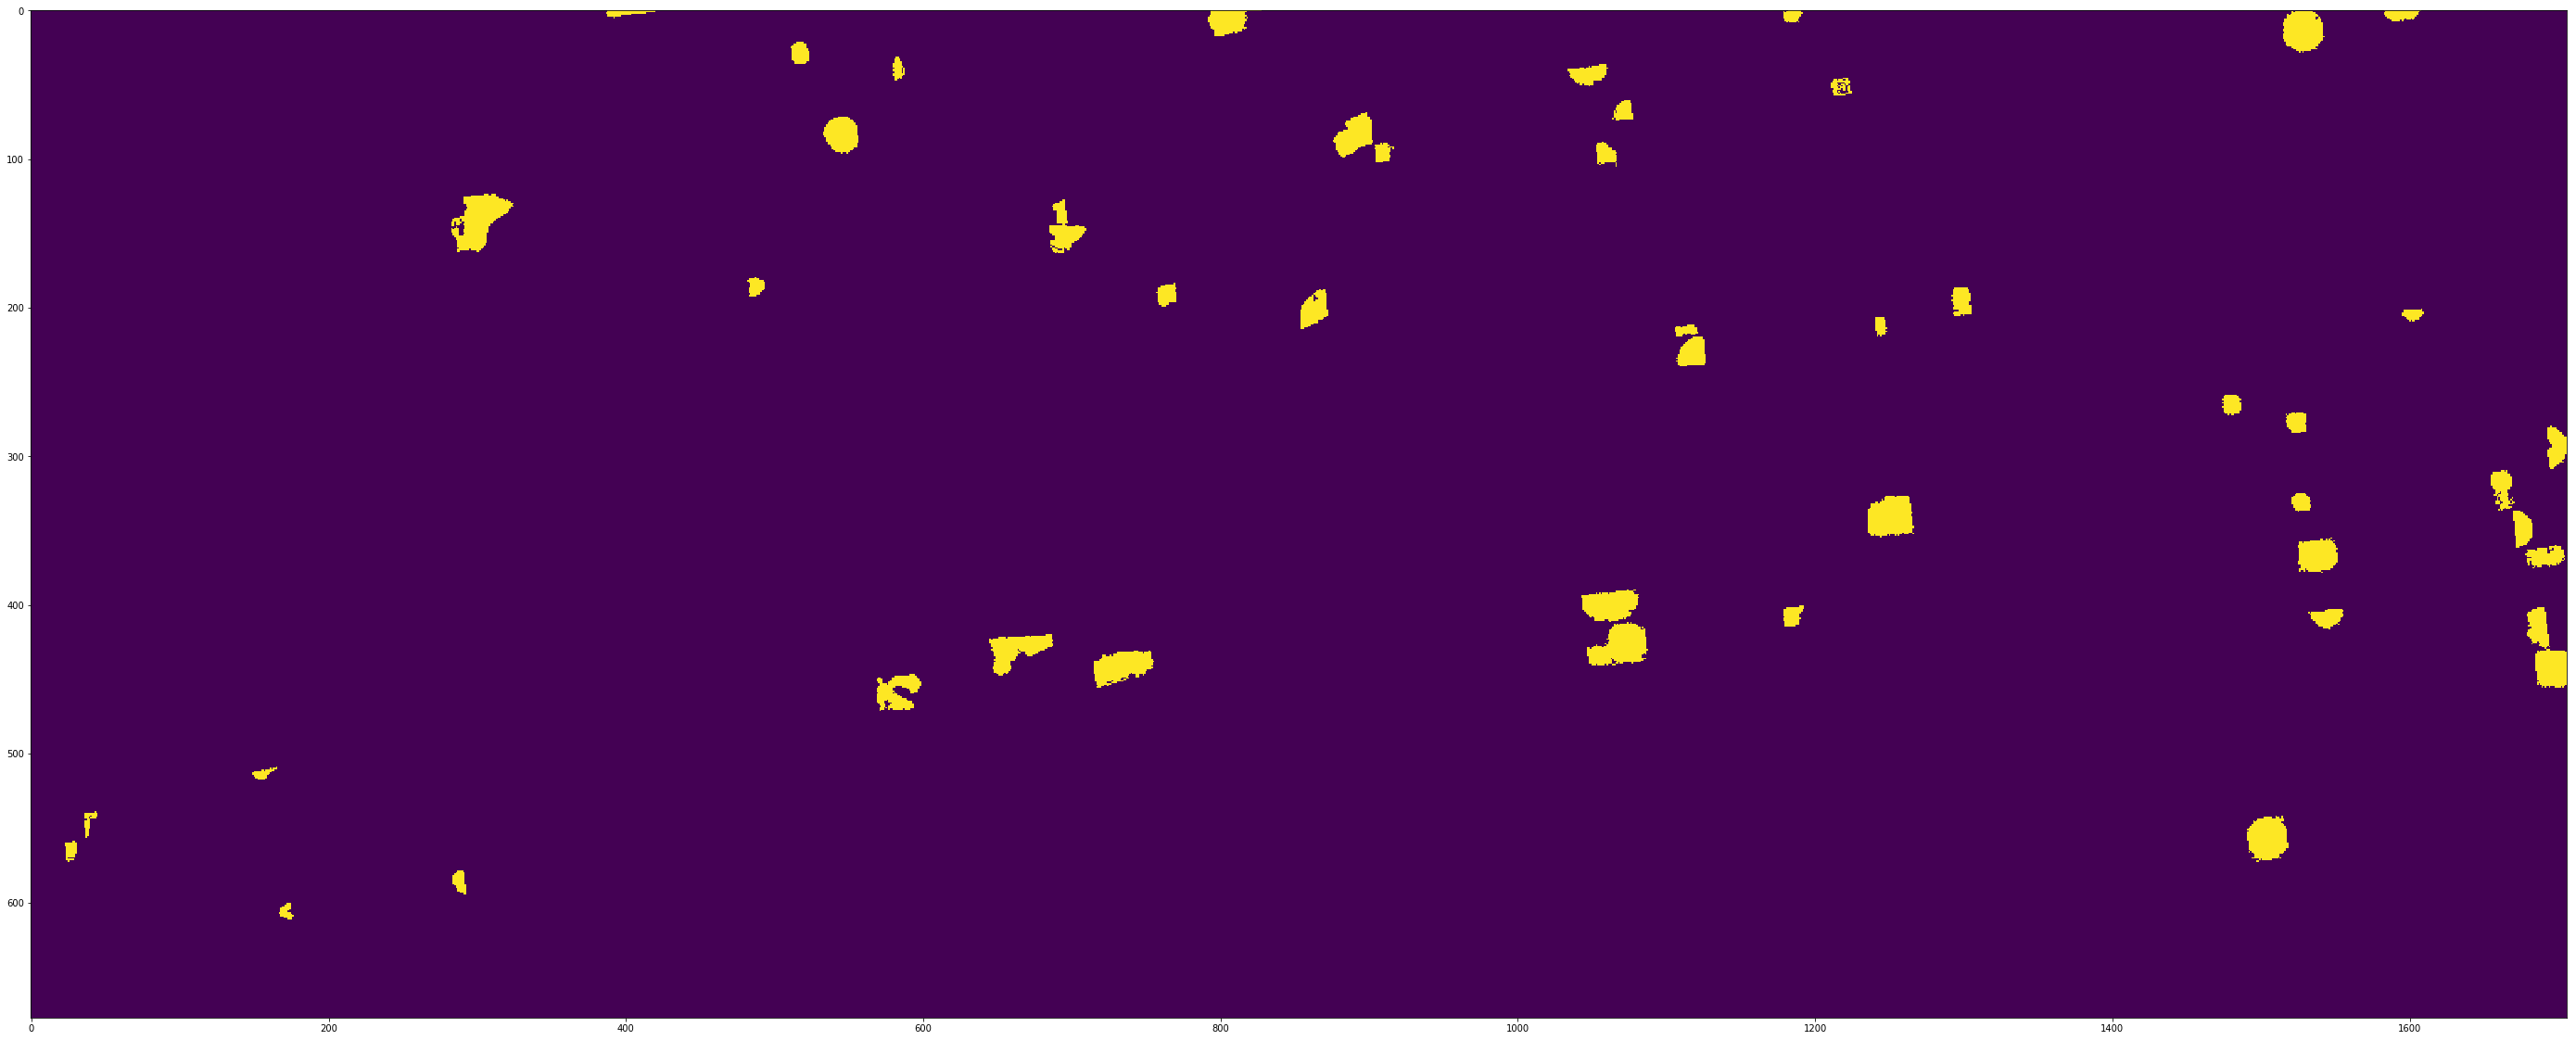

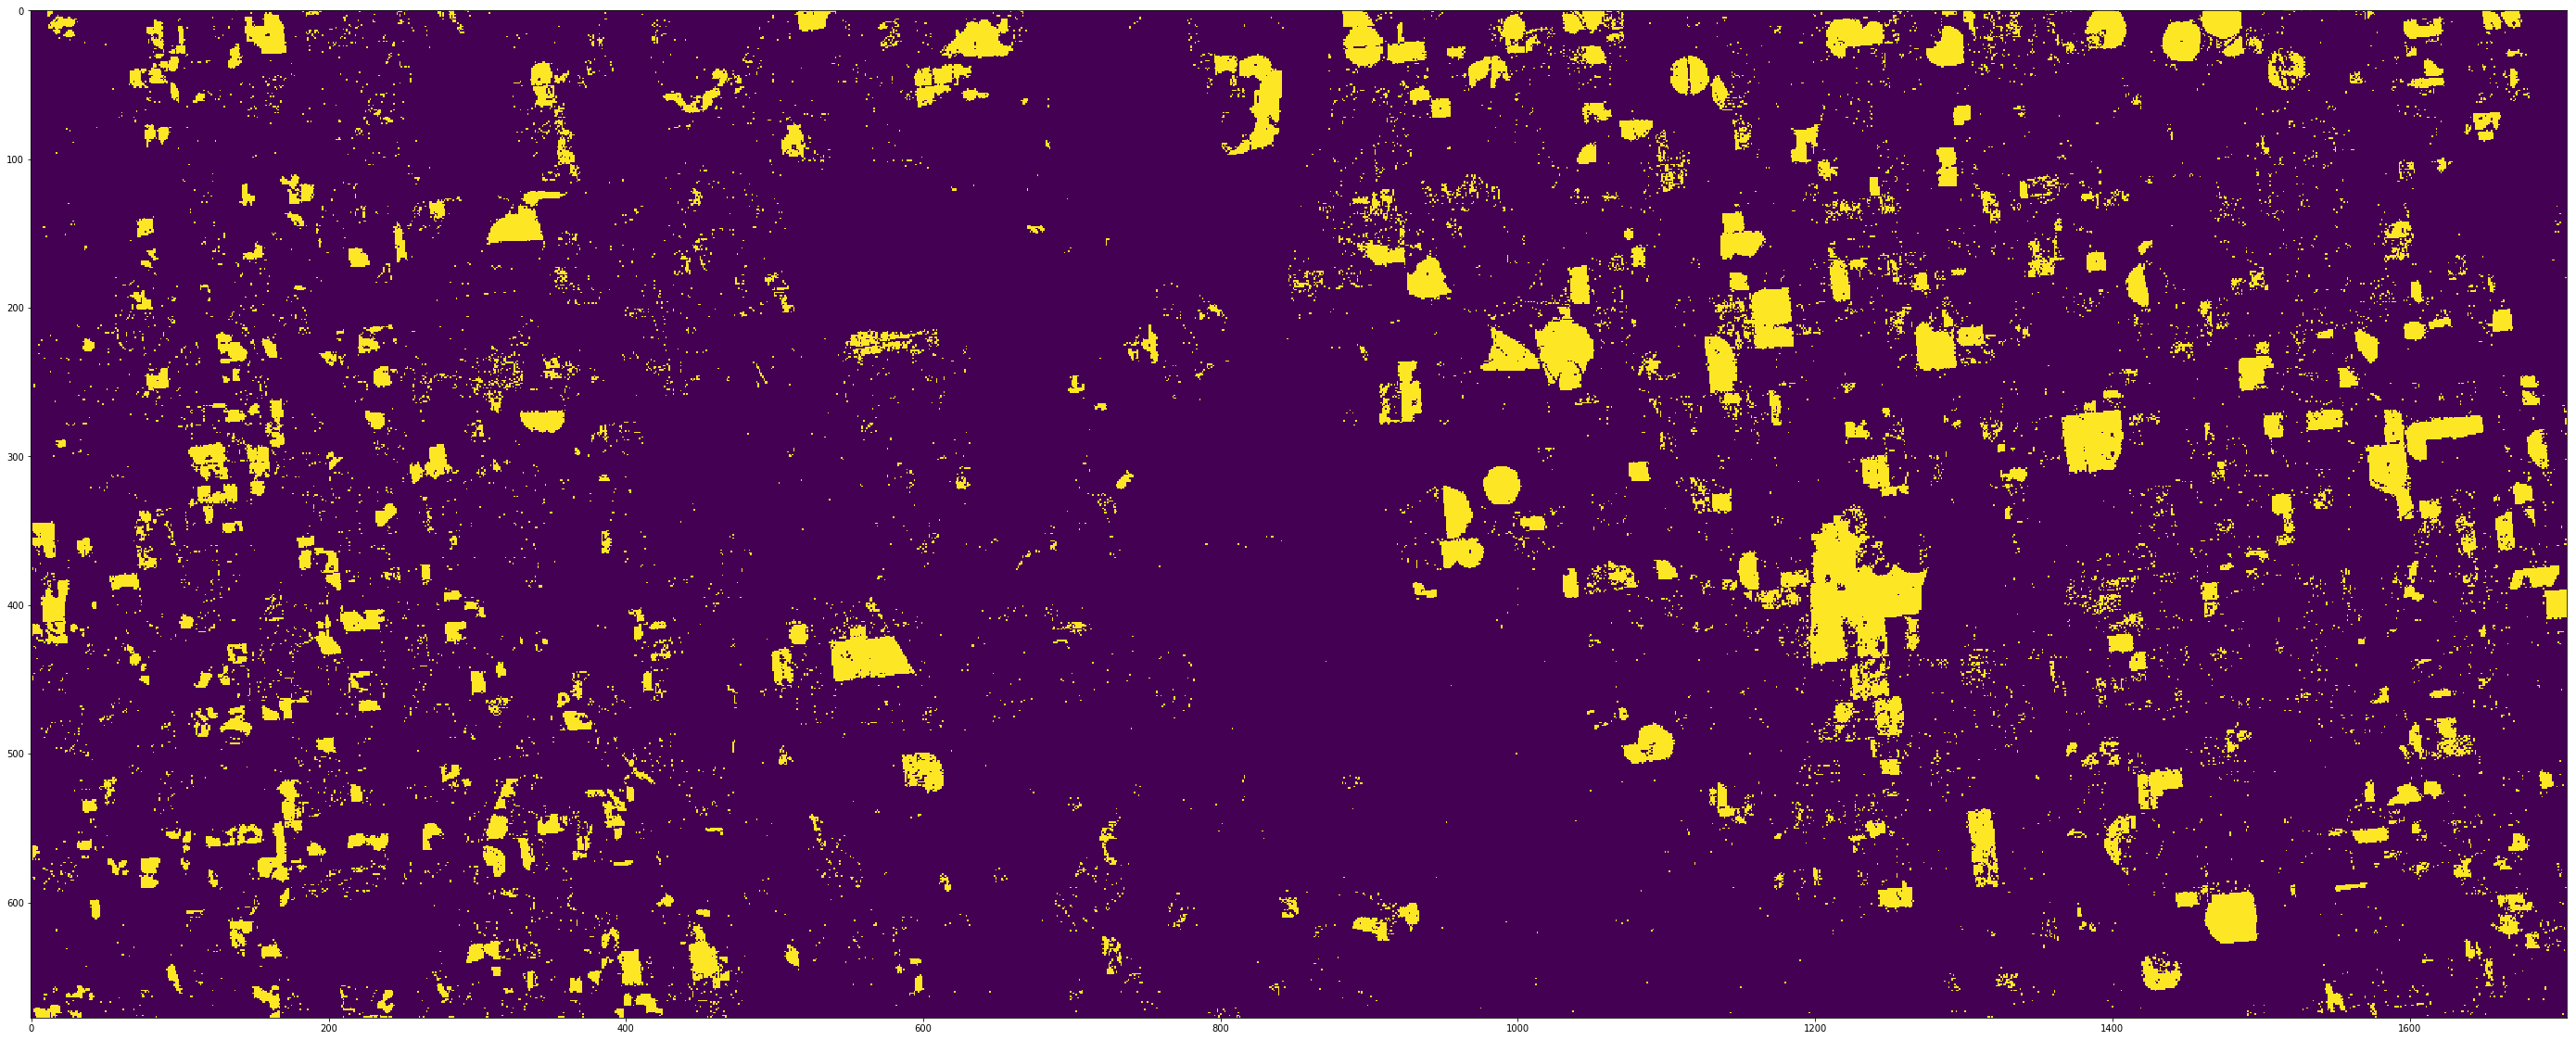

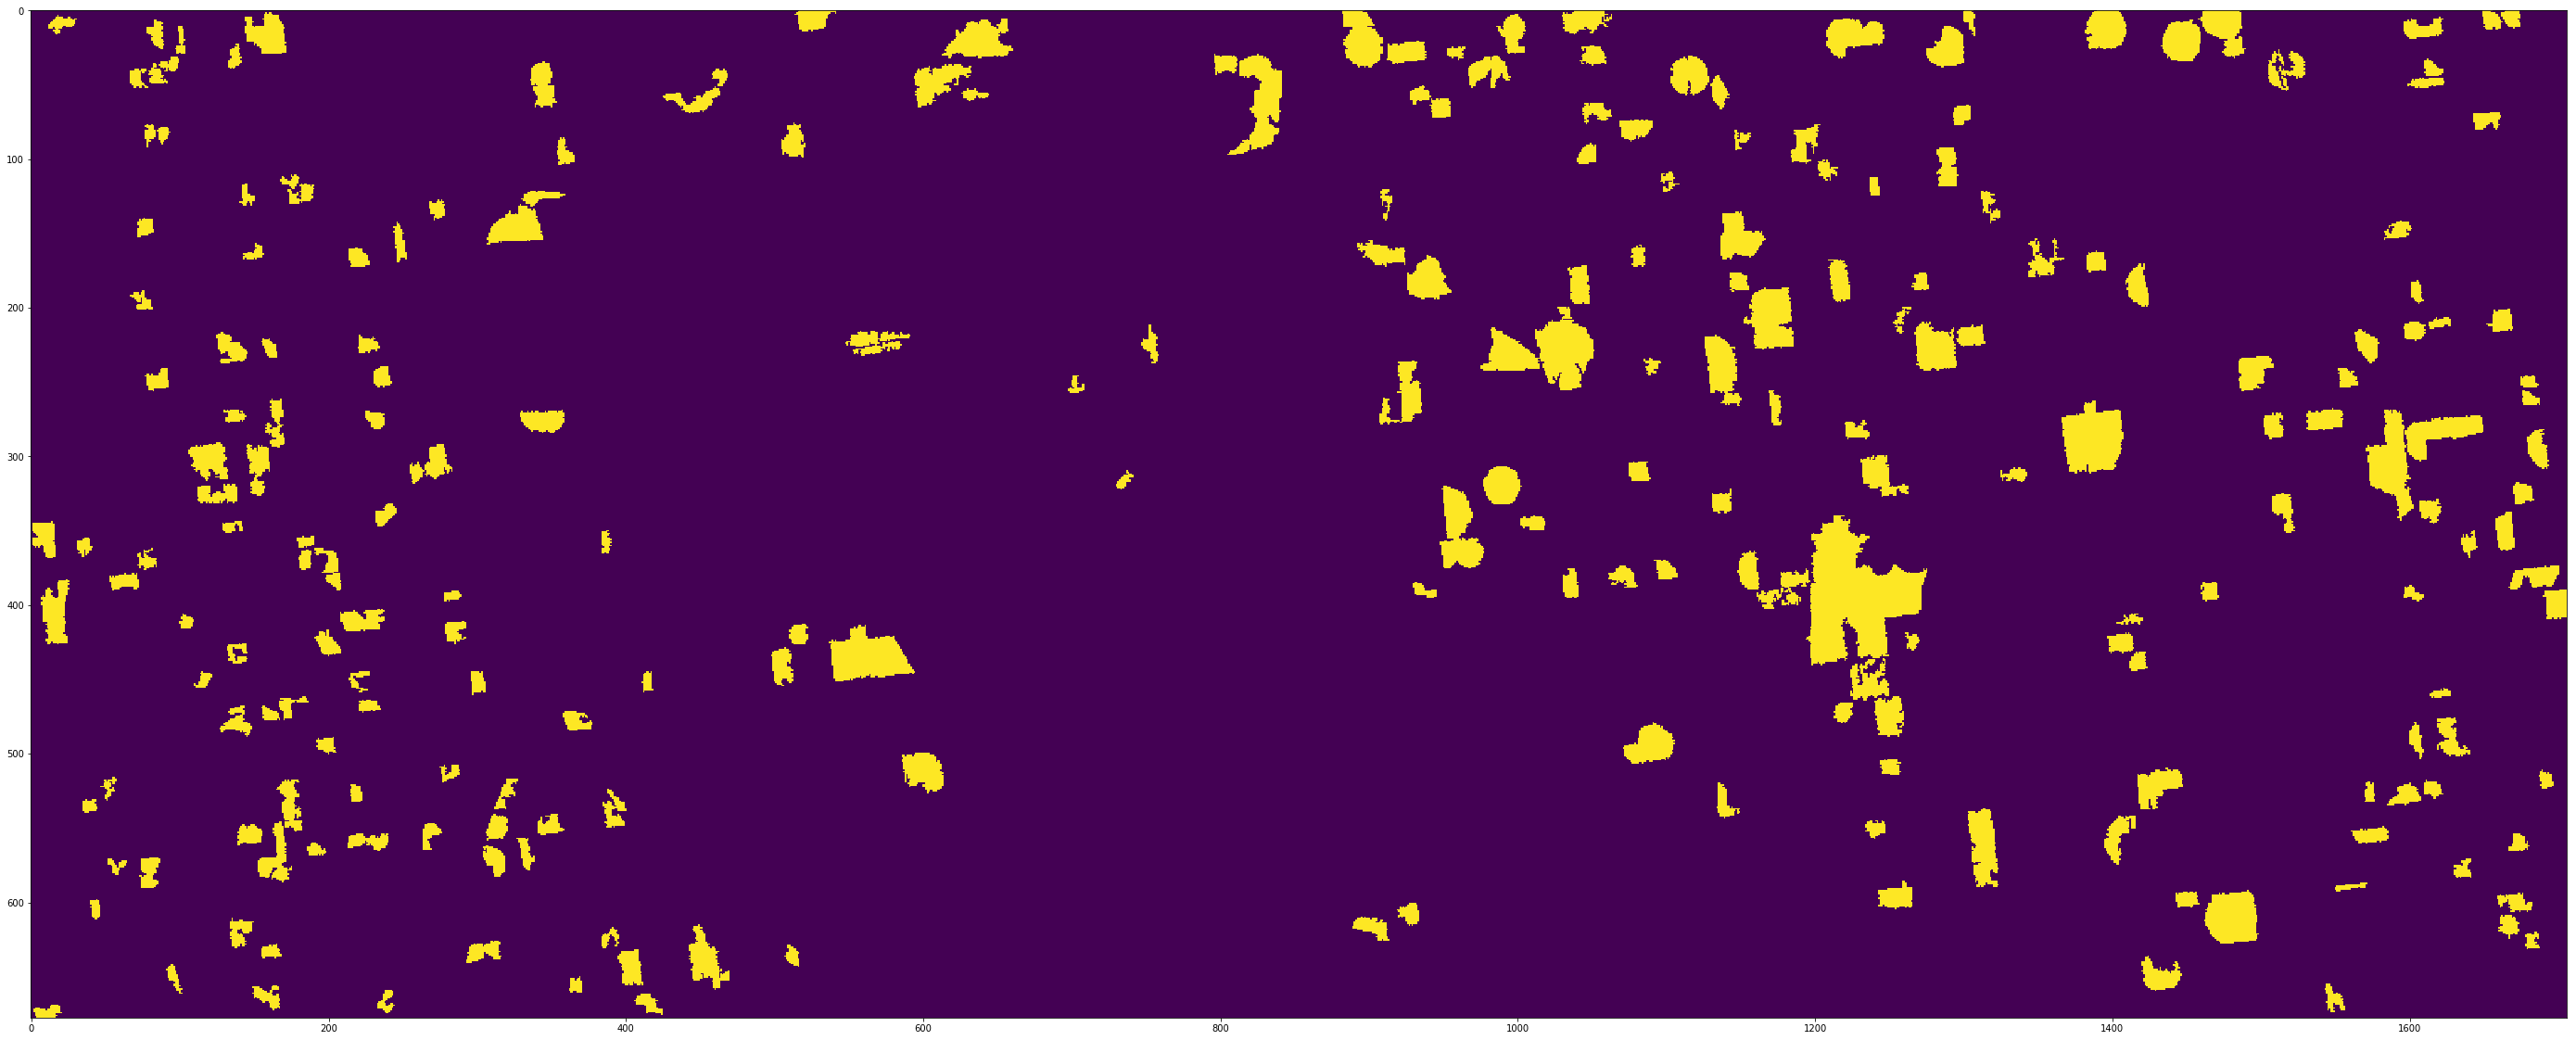

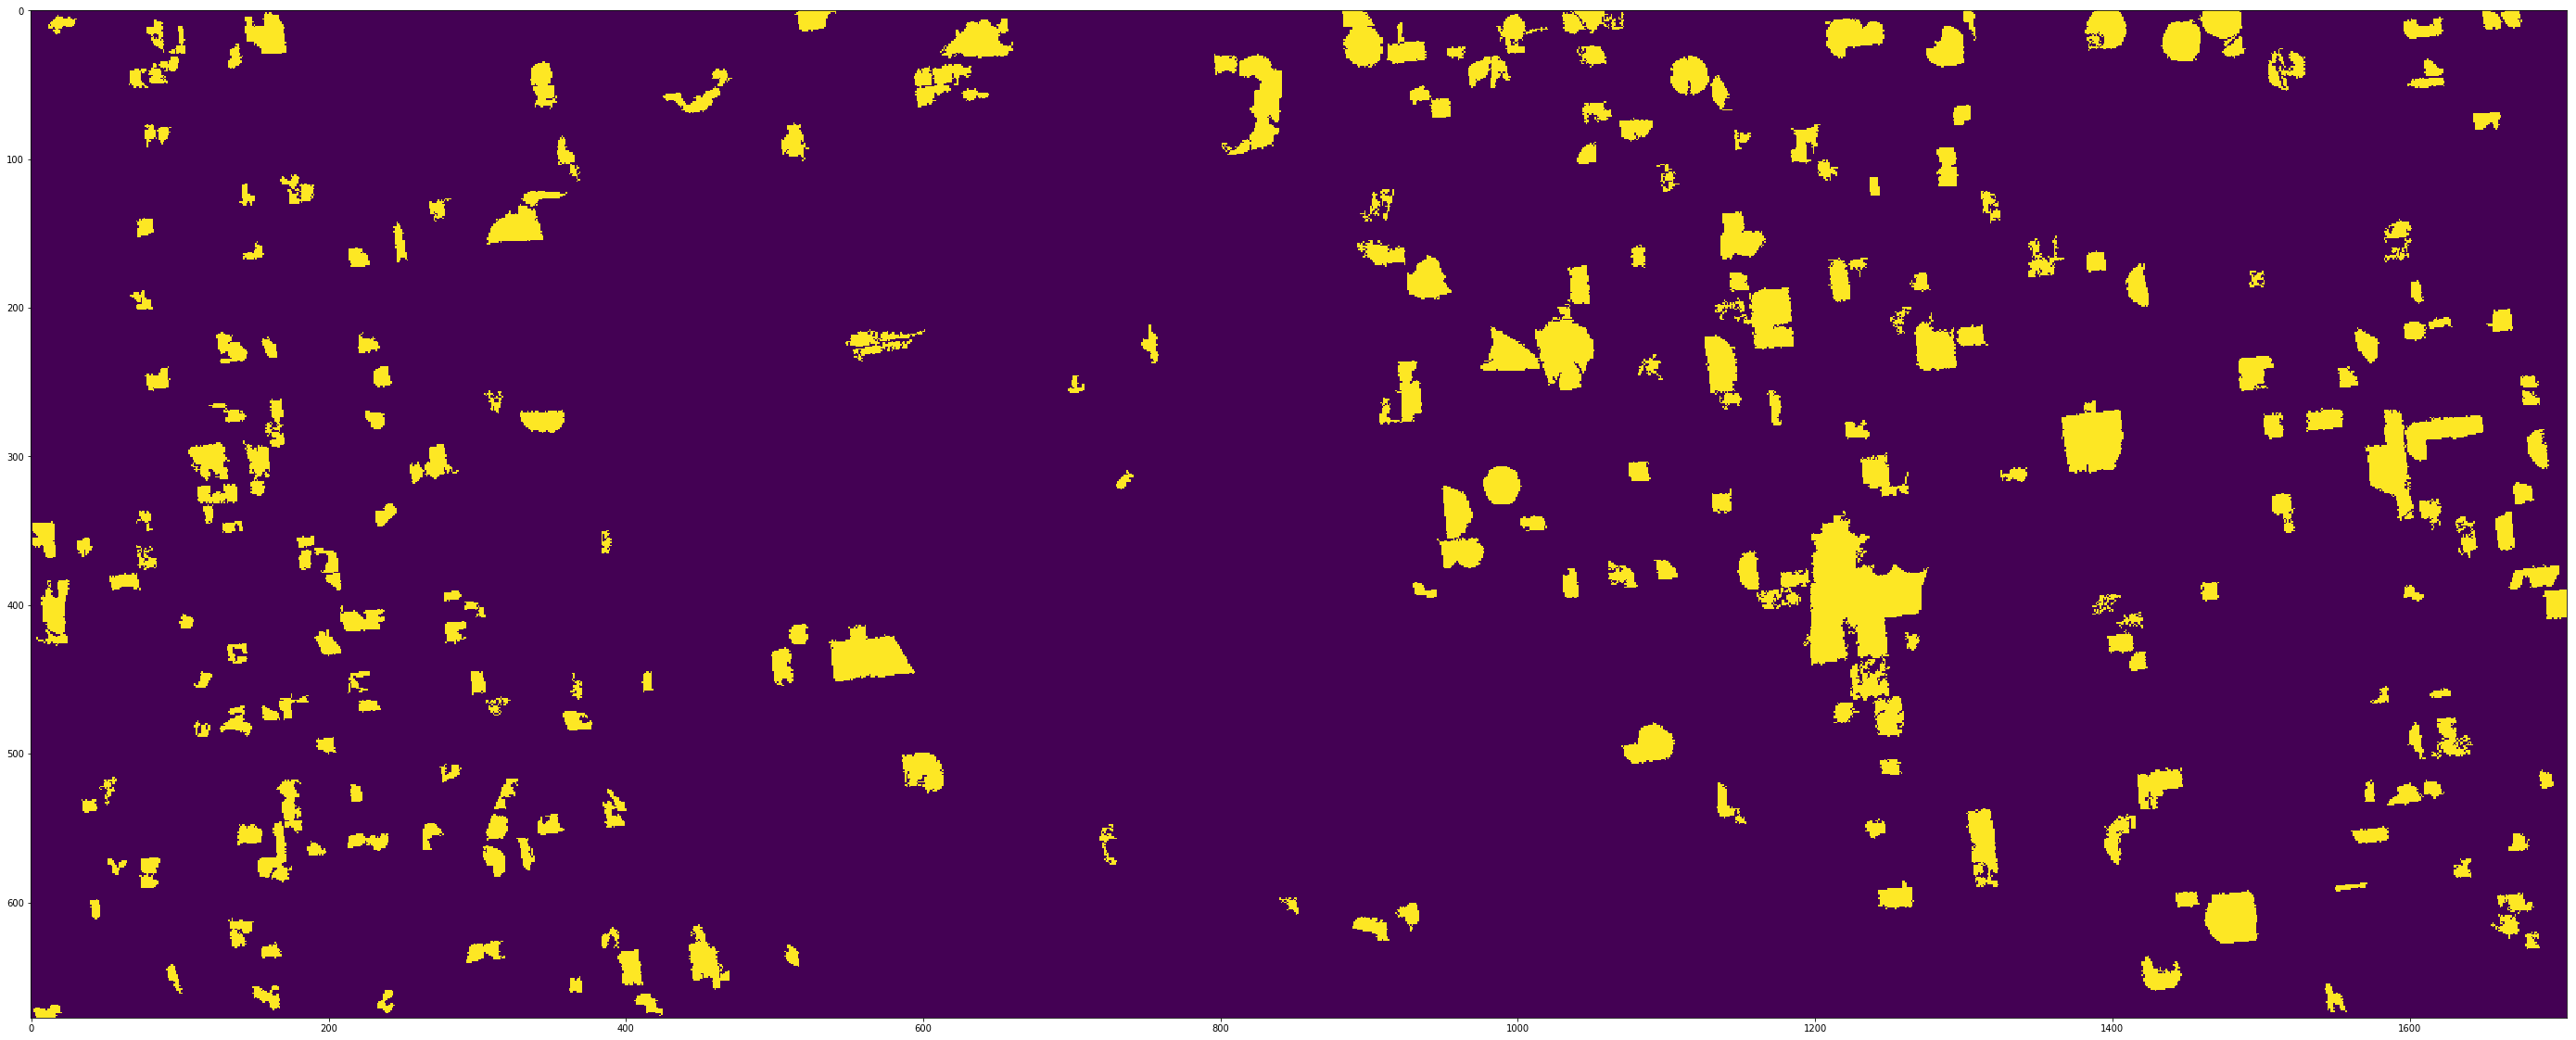

In [4]:
parcel_list_1 = []
parcel_list_2 = []
threshold = 64

for testing in crops_arrays_list:
    opened_image_1 = skimage.morphology.area_opening(testing,connectivity=1,area_threshold=threshold)
    opened_image_2 = skimage.morphology.area_opening(testing,connectivity=2,area_threshold=threshold)

    #binary_opened_image = skimage.morphology.binary_opening(mask)

    #closed_image = skimage.morphology.area_closing(testing,connectivity=2,area_threshold=256)
    #binary_closed_image = skimage.morphology.binary_closing(binary_opened_image)

    #opening_followed_by_closing = skimage.morphology.area_closing(opened_image,connectivity=2,area_threshold=256)
    parcel_list_1.append(skimage.morphology.area_closing(opened_image_1,connectivity=1,area_threshold=threshold))
    parcel_list_2.append(skimage.morphology.area_closing(opened_image_2,connectivity=2,area_threshold=threshold))

    
#summed_map = parcel_list[0] + parcel_list[1] + parcel_list[2]    
# plt.figure(figsize=(50,20))
# plot.show(summed_map)
for idx,crop in enumerate(parcel_list_1):
    plt.figure(figsize=(50,20))
    plot.show(crops_arrays_list[idx])
    plt.figure(figsize=(50,20))
    plot.show(crop)
    plt.figure(figsize=(50,20))
    plot.show(parcel_list_2[idx])

In [5]:
#4-way connectivity
parcel_list = parcel_list_1
#8-way connectivity
#parcel_list = parcel_list_2
for idx,crop in enumerate(crop_name):
    temp = array_to_raster(parcel_list[idx], crops_tifs[idx], data_folder_path + crop + '_parcel_mask_' + str(threshold))
    temp = raster_to_vector_polygonize(temp, data_folder_path + shapefile_folder, crop + '_shapefile_'+ str(threshold))

# temp = array_to_raster(summed_map, crop_data_tif, data_folder_path + "summed_map")
# shapefile_save_name = "summed_map_shapefile"
# temp = raster_to_vector_polygonize(temp,data_folder_path + shapefile_folder, shapefile_save_name)

AttributeError: 'NoneType' object has no attribute 'CreateField'